# Classification with Convolutional Neural Net

- CIFAR10 data set을 이용해 plane, car, bird, cat 등의 이미지를 분류하는 문제를 풀어보도록 하겠습니다.

In [5]:
import torch
import torchvision
import torchvision.transforms as transforms

## Load Data & Preprocessing

In [6]:
# 우선 dataset을 불러와 정규화를 해야 합니다.

# torchvision.transforms.Compose() 여러개의 transform을 구성합니다.
# totensor, normalize를 구성합니다.
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

# trainset
trainset = torchvision.datasets.CIFAR10(root='./data',train=True,download=True,transform=transform)

# num_workers는 사용하는 cpu의 갯수를 뜻합니다. batch_size = 4입니다.
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,shuffle=True,num_workers=2)

# testset
testset = torchvision.datasets.CIFAR10(root='./data',train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')

Files already downloaded and verified
Files already downloaded and verified


truck horse plane plane


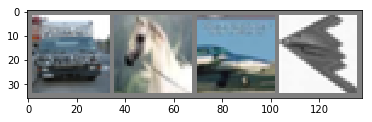

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# image show 함수
# torchvision.utils.make_grid(images) 는 -1 ~ 1의 범위를 갖습니다. 
# plot을 그리기 위해 우선 0~1 범위로 변경합니다.
# numpy()로 넣어주고 가로로 4개의 이미지를 보여주기 위해 transpose로 차원 위치를 변경합니다.

def imshow(img):
    img = img / 2 +0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))

# 학습용 이미지를 iter()로 하나씩 가져오기
dataiter = iter(trainloader)
images, labels = dataiter.next()

#정답 출력
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

#이미지 보여주기
imshow(torchvision.utils.make_grid(images))

In [41]:
torchvision.utils.make_grid(images).shape

torch.Size([3, 36, 138])

## Modeling

In [45]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        
        # 이제 3채널 이미지를 처리합니다.
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True)
        # in_channels = 3, out_channels(filter 개수) = 6, kernel_size = 5X5입니다.
        
        self.conv1 = nn.Conv2d(3,6,5)
    
        # torch.nn.MaxPool2d(kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)
        
        self.pool = nn.MaxPool2d(2,stride = 2)
                
        self.conv2 = nn.Conv2d(6,16,5)
        
        self.fc1 = nn.Sequential(
                            nn.Linear(6*6*16,576),
                            nn.ReLU()
                            )
        self.fc2 = nn.Sequential(
                            nn.Linear(576,100),
                            nn.ReLU()
                            )
        self.fc3 = nn.Sequential(
                            nn.Linear(100,10),
                            nn.ReLU()
                            )
    def forward(self, x):
        
        # conv1(), 36x36인데 kernel_size= 5x5, stride =1, padding =0이므로 output은 32x32x6입니다.
        # pool(), 32x32를 kernel_size = 2x2, stride = 2로 pooling합니다. output은 16x16x6입니다.
        
        x = self.pool(F.relu(self.conv1(x)))
        
        # conv2(), 16x16x6, kernel_size = 5x5, stride=1, padding = 0이므로 output은 12x12x16이 됩니다.
        # pool(), 12x12를 kernel_size = 2x2, stride =2로 pooling합니다. output은 6x6x16입니다.

        x = self.pool(F.relu(self.conv2(x)))
        
        x = x.view(-1,16*6*6)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x
    
net = Net()

## Loss function & Optimizer

In [46]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

## Training

In [47]:
for epoch in range(2): #데이터셋을 여러번 반복합니다.
    
    running_loss = 0.0
    for i, data in enumerate(trainloader,0): 
        
        # 입력을 받습니다.
        inputs, labels = data
        
        # gradient를 초기화합니다
        
        optimizer.zero_grad()
        
        # 순전파 -> 역전파 -> 최적화
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # loss 출력
        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i+1, running_loss/2000))
            running_loss =0.0
            
print("Finished Training")

RuntimeError: invalid argument 2: size '[-1 x 576]' is invalid for input with 1600 elements at ..\aten\src\TH\THStorage.cpp:80

## 시험용 데이터로 신경망 검사하기

GroundTruth:   cat  ship  ship plane


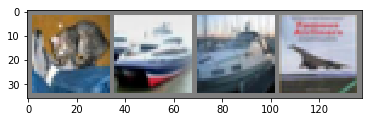

In [23]:
dataiter = iter(testloader) # iter, next를 이용해 test data 하나씩 꺼내옵니다.
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth:', ' '.join('%5s' % classes[labels[j]] for j in range(4))) # 시험용 데이터 4개를 출력합니다.

In [9]:
outputs = net(images) #output을 저장합니다.

In [10]:
_, predicted = torch.max(outputs,1) # 분류한 10개 class에서 어느 값이 가장 큰지, 몇번째 인덱스인지 알려줍니다.

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))
# cat ship ship plane을 cat ship ship ship으로 분류했습니다.

Predicted:    cat  ship  ship  ship


In [27]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct/total))
# 전체 데이터 셋에 대해서는 53%의 정확도를 보여줍니다.

Accuracy of the network on the 10000 test images: 53 %


In [29]:
class_correct = list(0. for i in range(10)) #빈 리스트 생성
class_total = list(0. for i in range(10))

with torch.no_grad(): #testloader에서 4개씩 불러와 class correct와 class total에 각각 알맞게 더해줍니다.
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs,1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 47 %
Accuracy of   car : 75 %
Accuracy of  bird : 34 %
Accuracy of   cat : 33 %
Accuracy of  deer : 35 %
Accuracy of   dog : 37 %
Accuracy of  frog : 83 %
Accuracy of horse : 55 %
Accuracy of  ship : 85 %
Accuracy of truck : 46 %


## GPU에서 학습하기

In [33]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
# 저는 CPU환경이라 cpu로 출력되지만 GPU 사용이 가능한 경우 gpu로 출력됩니다.

print(device)

cpu


In [34]:
net.to(device) # 모든 텐서를 cuda tensor로 변경합니다.

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [35]:
inputs,labels = inputs.to(device), labels.to(device)